In [1]:
# 분별 모델
    # SVM, 다층 퍼셉트론, 컨볼류션 신경망, LSTM, 강화학습
    # 표정을보고 감정이나 상태를 알아내는 능력....

# 생성 모델  - deepfake(딥 페이크)
    # 사람의 필기체를 학습... 흉내내는 인공지능
    # HMM : 예전방식
    
    # 2010년~~ 딥러닝 기반의 생성모델
    # GAN : 최신

# 확률적 생성 모델
    # 이미지의 화소 각각에 대해 독립적으로 발생 확률을 추정-> 추정치를 화소값으로 생성하는 단순한모델

In [2]:
# 확률 생성모델을 MNIST에 적용
import numpy as np
from tensorflow.keras.datasets import mnist

In [3]:
(x_train,y_train),(x_target, y_target) =  mnist.load_data()

In [7]:
print(y_train[:10])
np.isin(y_train[:10], [0])

[5 0 4 1 9 2 1 3 1 4]


array([False,  True, False, False, False, False, False, False, False,
       False])

In [14]:
X = x_train[np.isin(y_train,[0])] # 확률 생성모델에.. 필기체가 0일때를 적용  
X.shape

(5923, 28, 28)

In [22]:
# 화소 수준으로 확률 생성 모델  실제 이미지  rgb색상이 적용된 3차원텐서 reshape 28,28,3
# (28,28,256)
#  화소별로 0~255 명함값의 빈도를 구하고 확률로 변환
a = np.zeros((28,28,256))
print(a.shape)
for k in range(X.shape[0]):   # 5923
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            a[i][j][X[k][i][j]] += 1
a = a / X.shape[0]            

(28, 28, 256)


In [23]:
# 확률생성모델을 이용해서 20개의 샘플을 생성
Xnew = np.zeros((20,28,28))
for i in range(20):
    for r in range(28):
        for c in range(28):
            Xnew[i][r][c]  = np.random.choice(range(256),p=a[r][c])  # 확률 분포에 따른 난수를 생성해서 화소 값을결정

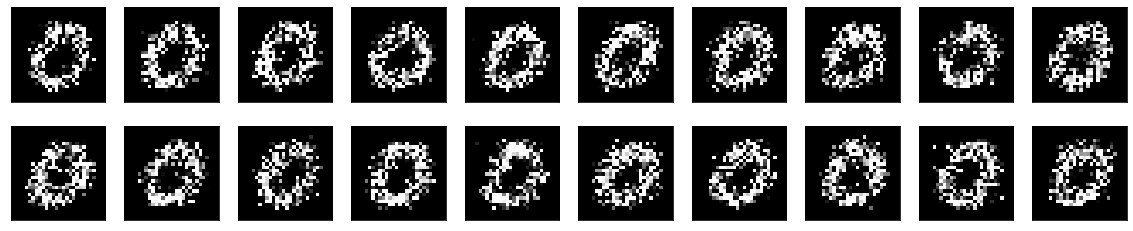

In [24]:
# 화소수준으로 확률적 생성모델이 만든 패턴
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
for i in range(2):
    for j in range(10):
        plt.subplot(2,10,i*10+j+1)
        plt.imshow(Xnew[i*10+j],cmap='gray')
        plt.xticks([]); plt.yticks([])
plt.show()        

In [25]:
# 0형태를유지하지만 품질이 낮다.... 화소간의 상간관계를 고려하지 않았기 때문...

In [26]:
# 오토인코더와 GAN이 대신 해 줌......

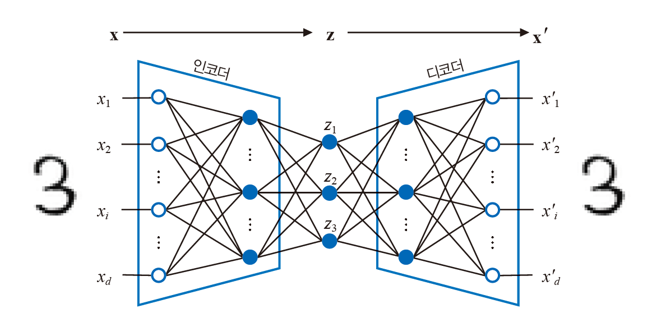

In [28]:
# 오토인코더 : 입력패턴과 출력 패턴이 같은 신경망 
    # 사람이 레이블을 달 필요가 없는 비 지도 학습
    # 영상압축, 잡음제거 -> 일반적인 응용
    # 특징 추출하거나 생성모델--> 딥러닝에서 응용
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/85.PNG", width=500)    
# 은닉층 노드 개수를 축소해서 설계
# 인코더는 차원을 줄이고 디코더는 차원을 회복. z 공간을 잠복 공간 latent space

In [30]:
# mnist를가지고 오토 인코더를 구현 --> 차원을 축소해서 특징을 찾아내는...... 
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input,Dense,Flatten, Reshape,Conv2D, Convolution2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k

In [32]:
# 데이터 로드및 가공
(x_train,y_train),(x_target,y_target) = mnist.load_data()
x_train = x_train / 255.0 ; x_target = x_target / 255.0
x_train.shape

(60000, 28, 28)

In [34]:
x_train = x_train.reshape(-1,28,28,1)
x_target = x_target.reshape(-1,28,28,1)
x_train.shape, x_target.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [35]:
# 잠복공간
zdim = 32

In [36]:
# 오토인코더 
encorder_input = Input(shape=(28, 28, 1))
x = Conv2D(32,(3,3),activation='relu',padding='same',strides=(1,1))(encorder_input)
x = Conv2D(64,(3,3),activation='relu',padding='same',strides=(2,2))(x)
x = Conv2D(64,(3,3),activation='relu',padding='same',strides=(1,1))(x)
x = Flatten()(x)
encorder_output = Dense(zdim)(x)
model_encorder = Model(encorder_input,encorder_output)
model_encorder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 32)                401440    
                                                                 
Total params: 457,184
Trainable params: 457,184
Non-trainable

In [39]:
# 오토디코더를 설계
decorder_input = Input(shape=(zdim,))
x=Dense(12544)(decorder_input)
x = Reshape((14, 14, 64))(x)
x = Convolution2DTranspose(64,(3,3),activation='relu', padding='same',strides=(1,1))(x)
x = Convolution2DTranspose(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Convolution2DTranspose(32,(3,3),activation='relu', padding='same',strides=(1,1))(x)
x = Convolution2DTranspose(1,(3,3),activation='relu', padding='same',strides=(1,1))(x)
decorder_output = x
model_decoder = Model(decorder_input,decorder_output)
model_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 12544)             413952    
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 32)       1846